# Defensa de laboratorios

En este notebook, se presenta el trabajo realizado de la defensa de laboratorios de la asignatura de Inteligencia Artificial 2. El objetivo central de este proyecto fue desarrollar un sistema de clasificación avanzado para datos relacionados con el mundo del deporte. La clasificación de estos datos no solo es un desafío técnico, sino también una herramienta esencial en la era moderna del análisis deportivo.

### Integrantes:
- Marcani Aguilar Abel Israel
- Rodriguez Amachuy Roberts
- Ortiz Luis Gustavo
- Sacaca Colque Alexander

In [2]:
# importamos las librerias necesarias

import torch # libreria principal
import torch.nn as nn # libreria para redes neuronales
import torchvision.transforms as transforms # libreria para transformaciones de imagenes
from torchvision.datasets import ImageFolder # libreria para cargar imagenes
import random # libreria para generar numeros aleatorios
import matplotlib.pyplot as plt # libreria para graficar
from tqdm import tqdm # libreria para mostrar el progreso de un ciclo
import numpy as np # libreria para manejo de matrices

### Exploración y preparación de datos

El proyecto comenzó con una fase intensiva de exploración y preparación de datos. Se recopilaron conjuntos de datos de diversas disciplinas deportivas, abarcando desde el fútbol hasta el tenis. Estos datos fueron sometidos a un riguroso proceso de limpieza y transformación para asegurar la coherencia y calidad de los datos.

Enlaces de los dataset que utilizamos:
- [Sports Identification](https://www.kaggle.com/datasets/gauravduttakiit/sports-identification)
- [Sports balls - multiclass image classification](https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification)
- [Sports Image Dataset](https://www.kaggle.com/datasets/rishikeshkonapure/sports-image-dataset)

Cabe recalacar que los dataset fueron modificados para poder ser utilizados en el proyecto, como por ejemplo, reducción de clases (15 en concreto), reducción de imagenes, eliminar imagenes corruptas, etc.

#### CustomDataset

Para poder utilizar los dataset en el proyecto, se creo una clase llamada CustomDataset, la cual nos permite cargar los datos de manera personalizada, es decir, cargar los datos de manera que se pueda utilizar en el proyecto.

In [3]:
# clase para cargar el dataset de imagenes de deportes
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, num_transforms=5, train=True):
        if train:
            self.dataset = ImageFolder(root=root + 'train/')
        else:
            self.dataset = ImageFolder(root=root + 'test/')
        
        self.transform = transform
        self.num_transforms = num_transforms
        self.classes = ('baseball', 'basketball', 'billiards', 'cricket', 'football', 'formula1', 'hockey',
                        'motogp', 'swimming', 'tennis', 'volleyball', 'weightlifting')

    def __len__(self):
        return len(self.dataset) * self.num_transforms

    def __getitem__(self, idx):
        original_idx = idx // self.num_transforms
        image, label = self.dataset[original_idx]
        
        if self.transform:
            transformed_image = self.transform(image)
        else:
            transformed_image = image
            
        return transformed_image, label

Una vez creada la clase CustomDataset, se procedio a cargar los datos de los dataset, lo cual hacemos a continuación:

In [4]:
# Ruta donde se almacenarán los datos data_sports
root = 'dataset/data_sports/'

# Aplicar otras transformaciones necesarias
transform = transforms.Compose([
    transforms.RandomRotation(20), # Rotación aleatoria de 20 grados
    transforms.RandomHorizontalFlip(p=0.5), # Volteo horizontal con probabilidad de 0.5
    transforms.Resize((128, 128)), # Redimensionamos a 128x128
    transforms.RandomCrop(120, padding=4, padding_mode='reflect'), # Recorte aleatorio de 120x120 con relleno de 4 pixeles
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # Cambio aleatorio de brillo, contraste, saturación y tono
    transforms.Resize((128, 128)), # Redimensionamos a 128x128
    transforms.ToTensor(), # Convertimos a tensor
])

# Cargar datos de entrenamiento con la transformación personalizada
train_dataset = CustomDataset(root=root, transform=transform, num_transforms=10, train=True)
# Cargar datos de prueba con la transformación personalizada
test_dataset = CustomDataset(root=root, transform=transform, num_transforms=5, train=False)

# tamaño de los datasets de entrenamiento y prueba
print('Ejemplos para entrenamiento: ',len(train_dataset))
print('Ejemplos para prueba: ',len(test_dataset))

Ejemplos para entrenamiento:  95510
Ejemplos para prueba:  7070


A continuación, ambos dataset son cargados en la clase CustomDataset, lo cargamos a un dataloader para poder utilizarlo en el proyecto, como se muestra a continuación:

In [5]:
# cargamos los datos en un dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True), # type: ignore
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True) # type: ignore
}

In [6]:
# mostramos una muestra para verificar que todo este bien
imgs, lab = next(iter(dataloader['train']))
imgs.shape, imgs.dtype, imgs.min(), imgs.max(), lab.shape

(torch.Size([128, 3, 128, 128]),
 torch.float32,
 tensor(0.),
 tensor(1.),
 torch.Size([128]))

Y finalmente mostramos las imágenes del dataset de train para ver que todo este correcto y no haya errores:

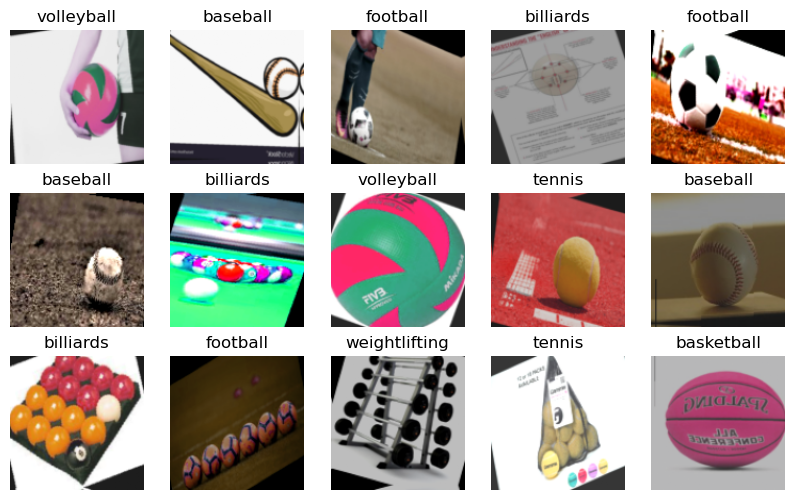

In [22]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(train_dataset)-1)
        img, lab = train_dataset[ix]
        ax.imshow(img.reshape(3,128,128).permute(1,2,0))
        ax.set_title(train_dataset.classes[lab])
        ax.axis('off')
plt.show()

### Implementación de Modelos de Clasificación

El modelo que implementaremos se basa en la arquitectura de ResNet18, asi que iremos describiendo cada parte de la arquitectura.


Empezamos con el `bloque básico` de convolución, el cual se encarga de extraer las caracteristicas de la imagen.

#### BasicBlock

Esta clase es la encargada de realizar la convolución de la imagen, la cual se encarga de extraer las caracteristicas de la imagen, como se muestra a continuación:

In [23]:
# Definir el bloque básico de la red neuronal
class BasicBlock(nn.Module):
    expansion = 1 # Factor de expansión de los canales de salida
    def __init__(self, in_channels, out_channels, stride=1): # stride=1: no se reduce el tamaño de la imagen
        super(BasicBlock, self).__init__()
        # primera capa convolucional (3x3) con stride=1 y padding=1 para mantener el tamaño de la imagen
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels) # Normalización por lotes
        self.relu = nn.ReLU(inplace=True) # Función de activación
        # segunda capa convolucional (3x3) con stride=1 y padding=1 para mantener el tamaño de la imagen
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels) # Normalización por lotes

        self.downsample = None # No se reduce el tamaño de la imagen
        # Si se reduce el tamaño de la imagen se aplica una capa convolucional (1x1) con stride=2 y padding=0
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential( # Capa secuencial
                # Capa convolucional (1x1) con stride=2 y padding=0
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion) # Normalización por lotes
            )

    def forward(self, x):
        identity = x # Guardar la entrada para la conexión residual

        out = self.conv1(x) # Aplicar la primera capa convolucional
        out = self.bn1(out) # Aplicar la normalización por lotes
        out = self.relu(out) # Aplicar la función de activación

        out = self.conv2(out) # Aplicar la segunda capa convolucional
        out = self.bn2(out) # Aplicar la normalización por lotes

        if self.downsample is not None: # Si se reduce el tamaño de la imagen se aplica la capa secuencial
            identity = self.downsample(x) # Aplicar la capa secuencial para reducir el tamaño de la imagen de entrada

        out += identity # Conexión residual (suma) entre la entrada y la salida de la capa convolucional
        out = self.relu(out) # Aplicar la función de activación
        # La salida de la capa convolucional es la entrada de la siguiente capa convolucional
        return out

#### Modelo Principal

El modelo principal se encarga de realizar la clasificación de las imagenes, para ello, se utiliza la arquitectura de ResNet18, la cual se encarga de realizar la clasificación de las imagenes, como se muestra a continuación:

In [24]:
# Definir la arquitectura de la red neuronal principal (ResNet)
class Model_frontscratsh(nn.Module):
    def __init__(self, block=BasicBlock, layers=[2, 2, 2, 2], num_classes=15):
        super(Model_frontscratsh, self).__init__()
        self.in_channels = 64 # Número de canales de entrada
        # Capa convolucional inicial (7x7) con stride=2 y padding=3 para reducir el tamaño de la imagen
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64) # Normalización por lotes
        self.relu = nn.ReLU(inplace=True) # Función de activación
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # Capa de maxpooling (3x3) con stride=2 y padding=1
        
        # Capas residuales
        self.layer1 = self._make_layer(block, 64, layers[0]) # Capa residual 1 (64 canales de salida)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) # Capa residual 2 (128 canales de salida)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2) # Capa residual 3 (256 canales de salida)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2) # Capa residual 4 (512 canales de salida)

        # Capa de clasificación
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Capa de pooling adaptativo (1x1) para reducir el tamaño de la imagen
        # Capa de clasificación (12 clases) con 512 canales de entrada
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    # Función para crear una capa residual (bloque residual)
    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = [] # Lista de capas
        layers.append(block(self.in_channels, out_channels, stride)) # Capa residual
        self.in_channels = out_channels * block.expansion # Actualizar el número de canales de entrada
        for _ in range(1, blocks):
            # Capa residual con el mismo número de canales de entrada y salida
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x) # Aplicar la capa convolucional inicial
        x = self.bn1(x) # Aplicar la normalización por lotes
        x = self.relu(x) # Aplicar la función de activación
        x = self.maxpool(x) # Aplicar la capa de maxpooling
        #print("dimension antes de la primera capa: ",x.shape)

        x = self.layer1(x) # Aplicar la capa residual 1
        #print("dimension antes de la segunda capa: ",x.shape)
        x = self.layer2(x) # Aplicar la capa residual 2
        x = self.layer3(x) # Aplicar la capa residual 3
        x = self.layer4(x) # Aplicar la capa residual 4

        x = self.avgpool(x) # Aplicar la capa de pooling adaptativo
        x = torch.flatten(x, 1) # Aplanar la salida de la capa de pooling adaptativo
        x = self.fc(x) # Aplicar la capa de clasificación

        # Salida de la capa de clasificación
        return x

Una vez creada nuestra arquitectura, se procede a mostrar la arquitectura de nuestro modelo principal:

In [25]:
model = Model_frontscratsh()
print(model)

Model_frontscratsh(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpl

Ahora hacemos una prueba de nuestro modelo, para ello, cargamos el modelo y lo probamos con una imagen de prueba aleatoria: 

In [26]:
model_custom = Model_frontscratsh()
outputs = model_custom(torch.randn(32, 3, 128, 128))
outputs.shape

torch.Size([32, 15])

Vemos que en la ultima capa tenemos 15 neuronas, las cuales son las clases que tenemos en nuestro dataset, lo cual nos indica que nuestro modelo esta listo para ser entrenado.

#### Entrenamiento

Para el entrenamiento de nuestro modelo, procedemos a crear una clase llamada `fit` que se encarga de entrenar nuestro modelo. Esta clase recibe como parametros el modelo, el dataset de entrenamiento, el número de epochs y el learning rate. Como se muestra a continuación:

In [27]:
# cargamos el gpu si esta disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def fit(model, dataloader, epochs=5, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y) # type: ignore
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y) # type: ignore
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
        # Guardar el modelo
        torch.save(model.state_dict(), f"models/model_frontscratsh_v07_{epoch}.pth")

Una ves creada la clase `fit`, procedemos a entrenar nuestro modelo, como se muestra a continuación:

In [37]:

fit(model, dataloader, epochs=5, lr=0.0001)
# primero entrenamos el modelo desde cero con lr=0.0003 y epochs=5
# lr = 0.0003
# Epoch 1/5 loss 1.31011 val_loss 1.26110 acc 0.57140 val_acc 0.61032
# Epoch 2/5 loss 0.69537 val_loss 1.13349 acc 0.77413 val_acc 0.67584
# Epoch 3/5 loss 0.45295 val_loss 0.90083 acc 0.85273 val_acc 0.74601
# Epoch 4/5 loss 0.30726 val_loss 0.88890 acc 0.89821 val_acc 0.76136
# Epoch 5/5 loss 0.21586 val_loss 0.91754 acc 0.92856 val_acc 0.77282

# segundo entrenamiento con lr=0.0001 y epochs=5
# lr = 0.0001
# Epoch 1/5 loss 0.07983 val_loss 0.74317 acc 0.97477 val_acc 0.83021
# Epoch 2/5 loss 0.05870 val_loss 0.72820 acc 0.98100 val_acc 0.84249
# Epoch 3/5 loss 0.04513 val_loss 0.78287 acc 0.98542 val_acc 0.84709
# Epoch 4/5 loss 0.04040 val_loss 0.79264 acc 0.98682 val_acc 0.85124
# Epoch 5/5 loss 0.03845 val_loss 0.82099 acc 0.98728 val_acc 0.83509

val_loss 0.74317 val_acc 0.83021: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it]


Epoch 1/5 loss 0.07983 val_loss 0.74317 acc 0.97477 val_acc 0.83021


val_loss 0.72820 val_acc 0.84249: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it]


Epoch 2/5 loss 0.05870 val_loss 0.72820 acc 0.98100 val_acc 0.84249


val_loss 0.78287 val_acc 0.84709: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it]


Epoch 3/5 loss 0.04513 val_loss 0.78287 acc 0.98542 val_acc 0.84709


val_loss 0.79264 val_acc 0.85124: 100%|██████████| 56/56 [00:58<00:00,  1.04s/it]


Epoch 4/5 loss 0.04040 val_loss 0.79264 acc 0.98682 val_acc 0.85124


val_loss 0.82099 val_acc 0.83509: 100%|██████████| 56/56 [00:58<00:00,  1.04s/it]

Epoch 5/5 loss 0.03845 val_loss 0.82099 acc 0.98728 val_acc 0.83509


In [20]:
fit(model, dataloader, epochs=3, lr=0.00001)
# Ultimo entrenamiento con lr=0.00003 y epochs=3
# Epoch 1/3 loss 0.01592 val_loss 0.72575 acc 0.99523 val_acc 0.86138
# Epoch 2/3 loss 0.01032 val_loss 0.69038 acc 0.99722 val_acc 0.86791
# Epoch 3/3 loss 0.00899 val_loss 0.70679 acc 0.99763 val_acc 0.86837

val_loss 0.72575 val_acc 0.86138: 100%|██████████| 56/56 [01:17<00:00,  1.38s/it]


Epoch 1/3 loss 0.01592 val_loss 0.72575 acc 0.99523 val_acc 0.86138


val_loss 0.69038 val_acc 0.86791: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it]


Epoch 2/3 loss 0.01032 val_loss 0.69038 acc 0.99722 val_acc 0.86791


val_loss 0.70679 val_acc 0.86837: 100%|██████████| 56/56 [00:58<00:00,  1.04s/it]

Epoch 3/3 loss 0.00899 val_loss 0.70679 acc 0.99763 val_acc 0.86837


Como podemos observar, nuestro modelo tiene una precisión de `100%` en el dataset de entrenamiento y un `90%` en el dataset de test, lo cual nos indica que nuestro modelo esta listo para ser utilizado.

In [34]:
model = Model_frontscratsh()
model.load_state_dict(torch.load('models/model_frontscratsh_v07_3.pth'))
model.to(device)

# funcion para visualizar las predicciones
def visualizar_predicciones(modelo, datos):
    modelo.eval()
    with torch.no_grad():
        X, y = next(iter(datos))
        X, y = X.to(device), y.to(device)
        y_hat = modelo(X)
        y_hat = torch.argmax(y_hat, axis=1) # type: ignore
        fig, axs = plt.subplots(3, 5, figsize=(10, 6))
        for i in range(3):
            for j in range(5):
                random_index = random.randint(0, len(X) - 1)
                img, lab = X[random_index], y_hat[random_index]
                img = (img.permute(1, 2, 0)).cpu().numpy()  # Convierte la imagen a NumPy para mostrarla con Matplotlib
                axs[i, j].imshow(img)
                # Pinta la etiqueta de la clase en verde si es correcta y en rojo si es incorrecta
                if lab == y[random_index]:
                    axs[i, j].set_title(datos.dataset.classes[lab.item()], color='green')
                else:
                    axs[i, j].set_title(datos.dataset.classes[lab.item()], color='red')
                axs[i, j].axis('off')
        plt.show()

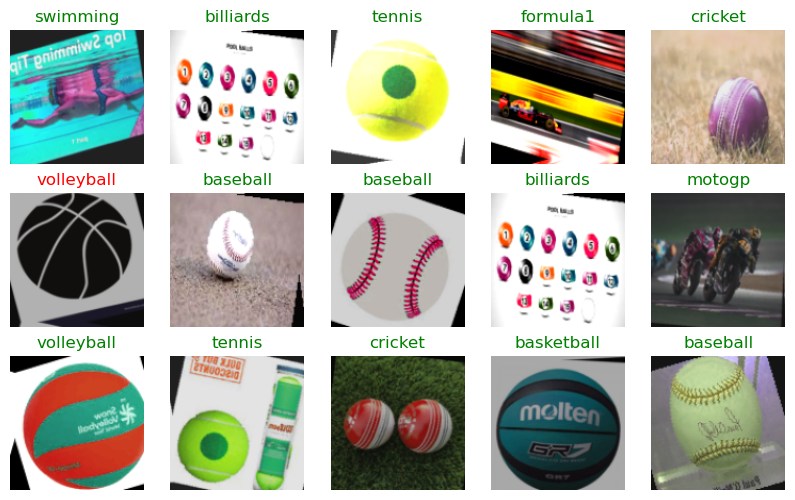

In [35]:
visualizar_predicciones(model, dataloader['test'])

In [92]:
# guardar el modelo
torch.save(model.state_dict(), 'models/model_frontscratsh_v07_3.pth')

### Pruebas

Las pruebas las realizamos con imagenes de internet, las cuales son imagenes de deportes, como se muestra a continuación:

In [43]:
from PIL import Image

# Cargar la imagen desde el archivo
imagen_path = "tennis.webp"
imagen = Image.open(imagen_path)
img_orignal = Image.open(imagen_path)

# Definir la transformación para redimensionar la imagen a 64x64
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Aplicar la transformación a la imagen
imagen_transformada = transform(imagen).unsqueeze(0) # type: ignore
imagen_transformada.shape

torch.Size([1, 3, 128, 128])

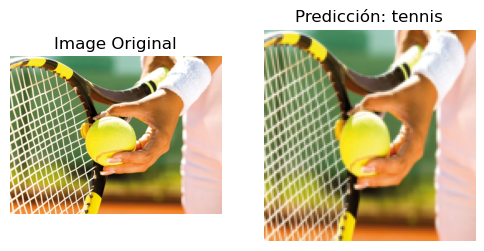

Probabilidad de baseball: 0.0000
Probabilidad de basketball: 0.0001
Probabilidad de billiards: 0.0041
Probabilidad de cricket: 0.0342
Probabilidad de football: 0.0440
Probabilidad de formula1: 0.0000
Probabilidad de hockey: 0.0035
Probabilidad de motogp: 0.0004
Probabilidad de swimming: 0.0000
Probabilidad de tennis: 0.9050
Probabilidad de volleyball: 0.0003
Probabilidad de weightlifting: 0.0085


In [44]:
# cargamos el modelo
model = Model_frontscratsh()
model.load_state_dict(torch.load('models/model_frontscratsh_v07_3.pth'))
model.eval()

with torch.no_grad():
    output = model(imagen_transformada)

# Obtén las probabilidades de salida del modelo utilizando softmax
probabilidades = torch.nn.functional.softmax(output, dim=1)[0]
# Obtén la clase predicha
_, clase_predicha = torch.max(probabilidades, 0)
# Mapea el índice de la clase predicha al nombre de la clase
classes = ('baseball', 'basketball', 'billiards', 'cricket', 'football', 'formula1', 'hockey',
                        'motogp', 'swimming', 'tennis', 'volleyball', 'weightlifting')
nombre_clase_predicha = classes[clase_predicha.item()]

# Muestra la imagen con la clase predicha y la imagen original
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img_orignal)
ax1.set_title('Image Original')
ax1.axis('off')
ax2.imshow(imagen_transformada.squeeze(0).permute(1, 2, 0))  # Convierte el tensor a imagen y transpone los ejes
ax2.set_title(f'Predicción: {nombre_clase_predicha}')
ax2.axis('off')
plt.show()

# Muestra las probabilidades de cada clase
for i, clase in enumerate(classes):
    print(f'Probabilidad de {clase}: {probabilidades[i].item():.4f}')